In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
import gc
import cPickle as pickle

In [3]:
train_test=fastparquet.ParquetFile("../input/train_test.parq").to_pandas()

In [4]:
train_test.head()

date  store_nbr  item_nbr  onpromotion  log_unit_sales
index                                                        
0         0         24         4           -1        2.080078
1         0         24         5           -1        0.693359
2         0         24         6           -1        1.098633
3         0         24        13           -1        0.693359
4         0         24        17           -1        0.693359

In [5]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128867504 entries, 0 to 3370463
Data columns (total 5 columns):
date              int16
store_nbr         int8
item_nbr          int16
onpromotion       int8
log_unit_sales    float32
dtypes: float32(1), int16(2), int8(2)
memory usage: 2.2 GB


In [6]:
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))

### trans target

In [7]:
item_perishable_map=pd.read_csv("../input/items.csv",index_col=0)['perishable'].to_dict()

In [8]:
perishable_item_map={v:item_perishable_map[k]  for k,v in items_idx.items()}

In [9]:
s=train_test['item_nbr'].map(perishable_item_map)

In [10]:
s.shape

(128867504,)

In [11]:
train_test['scaled_log_unit_sales']=(train_test['log_unit_sales']+(np.sqrt(1.25)-1)*s*train_test['log_unit_sales']).astype(np.float16)

In [12]:
train_test.head()

date  store_nbr  item_nbr  onpromotion  log_unit_sales  \
index                                                           
0         0         24         4           -1        2.080078   
1         0         24         5           -1        0.693359   
2         0         24         6           -1        1.098633   
3         0         24        13           -1        0.693359   
4         0         24        17           -1        0.693359   

       scaled_log_unit_sales  
index                         
0                   2.326172  
1                   0.693359  
2                   1.098633  
3                   0.693359  
4                   0.775391

In [13]:
del s
gc.collect()

37619

In [14]:
train_test['scaled_log_unit_sales'].astype(np.float64).mean()

1.8088305281414505

In [15]:
train_test['scaled_log_unit_sales'].astype(np.float64).std()

0.9287268372598926

In [16]:
train_test['log_unit_sales'].astype(np.float64).mean()

1.7510193412229376

In [17]:
train_test['log_unit_sales'].astype(np.float64).std()

0.8815122465302372

In [18]:
train_test=train_test.drop("log_unit_sales",axis=1)

In [19]:
gc.collect()

38

### make date idx

In [20]:
def get_date_index():
    dim=[54, 4100, 1704]
    data=np.zeros(shape=dim,dtype=np.int16) 
    data[:,:,:]=range(1704)  
    return data
def get_store_index():
    dim=[54, 4100, 1704]
    data=np.zeros(shape=dim,dtype=np.int16) 
    data[:,:,:]=np.reshape(range(54),[54,1,1])  
    return data
def get_item_index():
    dim=[54, 4100, 1704]
    data=np.zeros(shape=dim,dtype=np.int16) 
    data[:,:,:]=np.reshape(range(4100),[1,4100,1])  
    return data

### make y0

In [21]:
dim=[54, 4100, 1704]
np.prod(dim)

377265600

In [22]:
data=np.empty(shape=dim,dtype=np.float16)* np.nan

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [23]:
data.nbytes/1024.**2

719.5770263671875

In [24]:
idxes=train_test[['store_nbr','item_nbr','date']].values.T
values=train_test['scaled_log_unit_sales'].values
idxes.shape,values.shape

((3, 128867504), (128867504,))

In [25]:
(~np.isnan(values)).sum()

125497040

In [26]:
data[tuple(idxes)]=values

In [27]:
(~np.isnan(data)).sum()

125497040

In [28]:
np.nanmean(data.astype(np.float64))

1.8088305281414505

In [29]:
np.savez_compressed("../input/s/y_0", data)

In [30]:
gc.collect()

0

In [31]:
npzfile = np.load("../input/s/y_0.npz")

In [32]:
npzfile.files

['arr_0']

In [33]:
train_test.head()

date  store_nbr  item_nbr  onpromotion  scaled_log_unit_sales
index                                                               
0         0         24         4           -1               2.326172
1         0         24         5           -1               0.693359
2         0         24         6           -1               1.098633
3         0         24        13           -1               0.693359
4         0         24        17           -1               0.775391

In [34]:
train_test['onpromotion'].value_counts()

 0    99200634
-1    21657651
 1     8009219
Name: onpromotion, dtype: int64

In [7]:
dim=(54, 4100, 1704)
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b

In [8]:
y0=get_series('y_0')

In [9]:
u=np.mean(np.isnan(y0).reshape([-1,1704]),0)

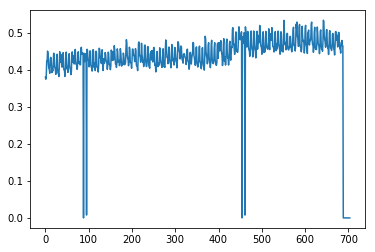

In [10]:
plt.plot(1-u[1000:])

### make_weekday

In [13]:
for i in range(7):
    data=np.ones_like(y0)*np.array([u%7==i for u in range(0,y0.shape[2])])
    print data.shape,data.dtype
    np.savez_compressed("../input/s/weekday{}_0".format(i), data)

(54, 4100, 1704) float16
(54, 4100, 1704) float16
(54, 4100, 1704) float16
(54, 4100, 1704) float16
(54, 4100, 1704) float16
(54, 4100, 1704) float16
(54, 4100, 1704) float16


### make onpromotion

In [11]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.empty(shape=dim,dtype=np.float16)
data.fill(np.nan)

377265600


In [12]:
data.nbytes/1024.**2

719.5770263671875

In [13]:
idxes=train_test[['store_nbr','item_nbr','date']].values.T
values=train_test['onpromotion'].values
idxes.shape,values.shape

((3, 128867504), (128867504,))

In [14]:
(~np.isnan(values)).sum()

128867504

In [15]:
data[tuple(idxes)]=values

In [16]:
(~np.isnan(data)).sum()

128867504

In [18]:
data[np.isnan(data)]=0

In [23]:
(np.isnan(data)).sum()

0

In [20]:
data.shape,data.dtype

((54, 4100, 1704), dtype('float16'))

In [21]:
np.savez_compressed("../input/s/onpromotionraw_0", data)

In [22]:
gc.collect()

153

In [9]:
u=get_series('onpromotionraw_0')
np.mean(np.isnan(u))

0.0

### make onpromotion

In [13]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.empty(shape=dim,dtype=np.float16)
data.fill(np.nan)

377265600


In [14]:
data.nbytes/1024.**2

719.5770263671875

In [15]:
idxes=train_test[['store_nbr','item_nbr','date']].values.T
values=train_test['onpromotion'].values
idxes.shape,values.shape

((3, 128867504), (128867504,))

In [16]:
(~np.isnan(values)).sum()

128867504

In [17]:
data[tuple(idxes)]=values

In [18]:
(~np.isnan(data)).sum()

128867504

In [19]:
test_promot=data[:,:,1688:]
train_promot=data[:,:,950:1688]

In [20]:
mean_train_prompt=np.sum(train_promot==1,-1)/(np.sum(train_promot>=0,-1)+1e-9)

In [21]:
test_promot.shape

(54, 4100, 16)

In [22]:
u=np.nanmean(train_promot.reshape([-1,688]),0)
plt.plot(u);

ValueError: cannot reshape array of size 163393200 into shape (688)

In [ ]:
u=np.nansum(test_promot.reshape([-1,16]),0)/54./4100
plt.plot(u);

In [ ]:
def f_train(i,j):
    arr= train_promot[i,j]
    idx=np.where(arr==-1)[0]
    p=mean_train_prompt[i,j]
    #print p
    d=int(len(idx)*p)
    arr[idx]=0   
    if j==6:
        print i,j, "made additional", d,len(idx),p
    if d>0:
        selected=np.random.choice(idx,d,replace=False)
        arr[selected]=1      

In [ ]:
if 0:
    for i in range(train_promot.shape[0]):
        for j in range(train_promot.shape[1]):
            f_train(i,j)

In [ ]:
for i in range(train_promot.shape[2]):
    s1=train_promot[:,:,i].reshape(-1)
    s2=y0[:,:,i+1000].reshape(-1)
    ind=s2>0
    print i, s1[ind].mean(),np.mean(ind),np.nansum(s1,dtype=np.float)/54./4100
    #break


In [23]:
for i in range(test_promot.shape[2]):
    s1=test_promot[:,:,i].reshape(-1)
    print i, np.nanmean(s1) ,np.isnan(s1).mean(),np.nansum(s1,dtype=np.float)/54./4100
    #break


0 0.14502 0.0485365853659 0.137935862692
1 0.035614 0.0485365853659 0.0338979223126
2 0.065369 0.0485365853659 0.0622267389341
3 0.040863 0.0485365853659 0.0389069557362
4 0.045197 0.0485365853659 0.0429674796748
5 0.038483 0.0485365853659 0.0365853658537
6 0.048798 0.0485365853659 0.0464995483288
7 0.078308 0.0485365853659 0.0745257452575
8 0.039276 0.0485365853659 0.0373441734417
9 0.066406 0.0485365853659 0.0631933152665
10 0.042908 0.0485365853659 0.0409259259259
11 0.048889 0.0485365853659 0.0465085817525
12 0.040283 0.0485365853659 0.038342366757
13 0.051575 0.0485365853659 0.0491237579042
14 0.10211 0.0485365853659 0.0970686540199
15 0.053497 0.0485365853659 0.0509530261969


In [24]:
print "nan percent (test,train)", np.isnan(test_promot).mean(),np.isnan(train_promot).mean()

nan percent (test,train) 0.0485365853659 0.559164787764


In [25]:
test_promot[np.isnan(test_promot)]=0

In [26]:
print 'test (nan percent, mean)', np.isnan(test_promot).mean(),np.nanmean(test_promot,dtype=np.float)

test (nan percent, mean) 0.0 0.0560628387534


In [27]:
print 'train (nan percent, mean)', np.isnan(train_promot).mean(),np.nanmean(mean_train_prompt,dtype=np.float)

train (nan percent, mean) 0.559164787764 0.0777627622113


In [28]:
mean_test_prompt=np.nanmean(test_promot,-1)

In [29]:
mean_test_prompt.min(),mean_test_prompt.max()

(0.0, 1.0)

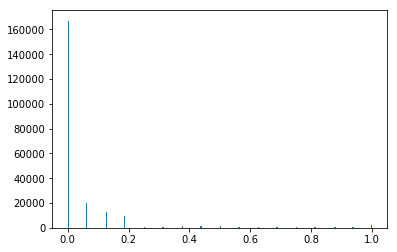

In [30]:
plt.hist(mean_test_prompt.reshape(-1),bins=200);


In [31]:
def f_train(i,j):
    arr= train_promot[i,j]
    idx=np.where(np.isnan(arr))[0]
    p=mean_test_prompt[i,j]
    #print p
    target_prompt=int(len(arr)*p)
    current_prompt=np.sum(arr==1)
    d=target_prompt-current_prompt
    arr[idx]=0
    if j==6:
        print i,j, "made additional", d,len(idx),p,target_prompt,current_prompt
    if d>0:
        if d >= len(idx):
            selected=idx
        else:
            selected=np.random.choice(idx,d,replace=False)
        arr[selected]=1
        

In [32]:
for i in range(train_promot.shape[0]):
    for j in range(train_promot.shape[1]):
        f_train(i,j)

0 6 made additional 364 7 0.5 369 5
1 6 made additional 366 18 0.5 369 3
2 6 made additional 369 14 0.5 369 0
3 6 made additional 369 9 0.5 369 0
4 6 made additional 367 7 0.5 369 2
5 6 made additional 318 8 0.4375 322 4
6 6 made additional 364 4 0.5 369 5
7 6 made additional 43 4 0.0625 46 3
8 6 made additional 0 738 0.0 0 0
9 6 made additional 0 738 0.0 0 0
10 6 made additional 0 738 0.0 0 0
11 6 made additional 0 737 0.0 0 0
12 6 made additional 0 738 0.0 0 0
13 6 made additional 0 737 0.0 0 0
14 6 made additional 0 738 0.0 0 0
15 6 made additional 0 738 0.0 0 0
16 6 made additional 0 738 0.0 0 0
17 6 made additional 0 738 0.0 0 0
18 6 made additional 0 738 0.0 0 0
19 6 made additional 0 738 0.0 0 0
20 6 made additional 0 738 0.0 0 0
21 6 made additional 0 738 0.0 0 0
22 6 made additional 181 14 0.25 184 3
23 6 made additional 42 57 0.0625 46 4
24 6 made additional 0 120 0.0 0 0
25 6 made additional 359 48 0.5 369 10
26 6 made additional 315 96 0.4375 322 7
27 6 made additional 0 73

In [33]:
print 'train (nan percent, mean)', np.isnan(train_promot).mean(),np.nanmean(train_promot[train_promot>=0],dtype=np.float)

train (nan percent, mean) 0.0 0.0649040963761


In [34]:
print 'test (nan percent, mean)', np.isnan(test_promot).mean(),np.nanmean(test_promot,dtype=np.float)

test (nan percent, mean) 0.0 0.0560628387534


In [35]:
print 'data (nan percent, mean)', np.isnan(data).mean(),np.nanmean(data,dtype=np.float)

data (nan percent, mean) 0.415787805726 -0.0449349719862


In [36]:
print data.min(),data.max()

nan nan


In [37]:
data.shape,data.dtype

((54, 4100, 1704), dtype('float16'))

In [39]:
for i in range(train_promot.shape[2]):
    s1=train_promot[:,:,i].reshape(-1)
    s2=y0[:,:,i+950].reshape(-1)
    ind=s2>0
    print i, s1[ind].mean(),np.mean(ind),np.nansum(s1,dtype=np.float)/54./4100
    #break


0 0.027969 0.369313459801 0.0407407407407
1 0.01651 0.380009033424 0.0359259259259
2 0.041382 0.366440831075 0.0455736224029
3 0.097534 0.366616982836 0.0662330623306
4 0.018768 0.356779584463 0.0381662149955
5 0.083069 0.366996386631 0.061684733514
6 0.016342 0.396210478771 0.0346025293586
7 0.025223 0.38778229449 0.0389295392954
8 0.016907 0.372077687444 0.0360388437218
9 0.041046 0.364869015357 0.0456549232159
10 0.096924 0.362592592593 0.0663233965673
11 0.018997 0.359367660343 0.0380261969286
12 0.085083 0.376219512195 0.0612737127371
13 0.018661 0.40017163505 0.035081300813
14 0.027542 0.395609756098 0.0384056007227
15 0.017761 0.379110207769 0.0355962059621
16 0.042816 0.371869918699 0.0452935862692
17 0.099365 0.370194218609 0.0663775971093
18 0.018158 0.363550135501 0.0370731707317
19 0.082947 0.372850045167 0.0607136404697
20 0.016434 0.407940379404 0.0332113821138
21 0.025803 0.40440831075 0.0375338753388
22 0.014534 0.390596205962 0.0339837398374
23 0.039825 0.407588075881 

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice.


 0.0364905149051
141 0.014091 0.421883468835 0.031332429991
142 0.039917 0.435280036134 0.0416485998193
143 0.092285 0.443753387534 0.0645347786811
144 0.016937 0.436693766938 0.0314498644986
145 0.092529 0.00775971093044 0.0773170731707
146 0.018173 0.455397470641 0.0301987353207
147 0.029251 0.453315266486 0.0351129177958
148 0.018036 0.436111111111 0.0314543812105
149 0.041809 0.426621499548 0.0425474254743
150 0.095703 0.422895212285 0.0651535682023
151 0.022125 0.408008130081 0.0349683830172
152 0.079041 0.413577235772 0.0578364950316
153 0.017944 0.451314363144 0.0306820234869
154 0.027115 0.449719963866 0.0346296296296
155 0.016022 0.413730803975 0.0322944896116
156 0.040833 0.407429990967 0.0419918699187
157 0.098755 0.403572719061 0.0659259259259
158 0.021835 0.396481481481 0.0357046070461
159 0.08429 0.412533875339 0.0607226738934
160 0.02269 0.45435862692 0.0324525745257
161 0.031525 0.450117434508 0.0371228545619
162 0.023804 0.417669376694 0.035108401084
163 0.052704 0.406

333 0.057068 0.416657633243 0.0488437217706
334 0.13257 0.427014453478 0.0808897922313
335 0.075134 0.461124661247 0.0554516711834
336 0.08606 0.460980126468 0.0609078590786
337 0.075195 0.428414634146 0.0561517615176
338 0.095154 0.418527551942 0.0643857271906
339 0.14502 0.416644083107 0.0856323396567
340 0.05957 0.405379403794 0.0506594399277
341 0.1203 0.428261065944 0.0755781391147
342 0.061401 0.468148148148 0.0497651309846
343 0.071594 0.462895212285 0.0536224028907
344 0.061157 0.435108401084 0.0500858175248
345 0.083496 0.423206865402 0.0596973803071
346 0.13928 0.428527551942 0.0838798554652
347 0.061737 0.41288166215 0.0509485094851
348 0.11053 0.422944896116 0.0717795844625
349 0.057709 0.460252935863 0.0481436314363
350 0.06781 0.453712737127 0.0523170731707
351 0.059052 0.434467028004 0.0494715447154
352 0.080688 0.422628726287 0.0586224028907
353 0.11621 0.419010840108 0.0737398373984
354 0.062927 0.405180668473 0.0523215898826
355 0.1178 0.431160794941 0.0753342366757
3

525 0.10333 0.504887082204 0.0697606142728
526 0.09552 0.468821138211 0.0654561878952
527 0.11969 0.455185185185 0.0765718157182
528 0.18604 0.454494128275 0.106359530262
529 0.10004 0.434882565492 0.0672673893406
530 0.15002 0.447235772358 0.0898193315266
531 0.091248 0.504756097561 0.0644715447154
532 0.10132 0.50179765131 0.0687850045167
533 0.090393 0.467416440831 0.0630532971996
534 0.11877 0.45413730804 0.0760523938573
535 0.18542 0.451278229449 0.10593495935
536 0.079041 0.432122854562 0.0578274616079
537 0.13025 0.454661246612 0.0810388437218
538 0.074219 0.503066847335 0.0555194218609
539 0.083008 0.50391598916 0.0595347786811
540 0.072632 0.455636856369 0.0545889792231
541 0.10089 0.473852755194 0.0685365853659
542 0.15015 0.492524841915 0.0923396567299
543 0.076538 0.473139114724 0.0562827461608
544 0.12915 0.47766034327 0.0816666666667
545 0.072144 0.519787714544 0.0540289069557
546 0.080261 0.509430894309 0.0583062330623
547 0.074219 0.470677506775 0.0548735320687
548 0.09

717 0.18689 0.452529358627 0.102705510388
718 0.082092 0.440058717254 0.0558536585366
719 0.1344 0.46549232159 0.0801219512195
720 0.081726 0.502786811201 0.0549367660343
721 0.091736 0.503563685637 0.0592502258356
722 0.081299 0.480438121048 0.0542457091238
723 0.092773 0.494033423668 0.0599954832882
724 0.15381 0.485085817525 0.0890063233966
725 0.076904 0.46174796748 0.0521544715447
726 0.13623 0.470523938573 0.0796160794941
727 0.078308 0.50081300813 0.0518428184282
728 0.086304 0.500605239386 0.0555781391147
729 0.079041 0.469101174345 0.0523667570009
730 0.10516 0.456806684734 0.0645799457995
731 0.15955 0.456115627823 0.0893721770551
732 0.080322 0.445103884372 0.053342366757
733 0.13562 0.472429990967 0.0792276422764
734 0.079041 0.475094850949 0.052064137308
735 0.087463 0.479218608853 0.0558807588076
736 0.078308 0.464051490515 0.0515040650407
737 0.10315 0.464345076784 0.0631300813008


In [40]:
for i in range(test_promot.shape[2]):
    s1=test_promot[:,:,i].reshape(-1)
    print i, np.nanmean(s1) ,np.isnan(s1).mean(),np.nansum(s1,dtype=np.float)/54./4100
    #break


0 0.13794 0.0 0.137935862692
1 0.033875 0.0 0.0338979223126
2 0.062195 0.0 0.0622267389341
3 0.038879 0.0 0.0389069557362
4 0.042999 0.0 0.0429674796748
5 0.036591 0.0 0.0365853658537
6 0.046417 0.0 0.0464995483288
7 0.074524 0.0 0.0745257452575
8 0.037354 0.0 0.0373441734417
9 0.063171 0.0 0.0631933152665
10 0.040833 0.0 0.0409259259259
11 0.046509 0.0 0.0465085817525
12 0.03833 0.0 0.038342366757
13 0.049072 0.0 0.0491237579042
14 0.097107 0.0 0.0970686540199
15 0.050903 0.0 0.0509530261969


In [41]:
data[np.isnan(data)]=0

In [42]:
np.savez_compressed("../input/s/onpromotion1000_0", data)

In [43]:
gc.collect()

31516

In [45]:
dim=(54, 4100, 1704)
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b

In [46]:
u=get_series('onpromotion1000_0')
np.isnan(u[:,:,1000:]).sum(),np.mean(np.isnan(u))

(0, 0.0)

In [47]:
u=get_series('onpromotion_0')
np.isnan(u[:,:,1000:]).sum(),np.mean(np.isnan(u))

(0, 0.0)

In [48]:
u=get_series('onpromotionraw_0')
np.isnan(u[:,:,1000:]).sum(),np.mean(np.isnan(u))

(0, 0.0)

### make onpromotion

In [7]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.empty(shape=dim,dtype=np.float16)
data.fill(np.nan)

377265600


In [8]:
data.nbytes/1024.**2

719.5770263671875

In [9]:
idxes=train_test[['store_nbr','item_nbr','date']].values.T
values=train_test['onpromotion'].values
idxes.shape,values.shape

((3, 128867504), (128867504,))

In [10]:
(~np.isnan(values)).sum()

128867504

In [11]:
data[tuple(idxes)]=values

In [12]:
(~np.isnan(data)).sum()

128867504

In [13]:
test_promot=data[:,:,1688:]
train_promot=data[:,:,:1688]

In [14]:
mean_train_prompt=np.sum(train_promot==1,-1)/(np.sum(train_promot>=0,-1)+1e-9)

In [15]:
def f_train(i,j):
    arr= train_promot[i,j]
    idx=np.where(arr==-1)[0]
    p=mean_train_prompt[i,j]
    #print p
    d=int(len(idx)*p)
    arr[idx]=0   
    if j==6:
        print i,j, "made additional", d,len(idx),p
    if d>0:
        selected=np.random.choice(idx,d,replace=False)
        arr[selected]=1      

In [16]:
if 0:
    for i in range(train_promot.shape[0]):
        for j in range(train_promot.shape[1]):
            f_train(i,j)

In [17]:
print "nan percent (test,train)", np.isnan(test_promot).mean(),np.isnan(train_promot).mean()

nan percent (test,train) 0.0485365853659 0.664197887634


In [18]:
test_promot[np.isnan(test_promot)]=0

In [19]:
print 'test (nan percent, mean)', np.isnan(test_promot).mean(),np.nanmean(test_promot,dtype=np.float)

test (nan percent, mean) 0.0 0.0560628387534


In [21]:
print 'train (nan percent, mean)', np.isnan(train_promot).mean(),np.nanmean(mean_train_prompt,dtype=np.float)

 train (nan percent, mean) 0.664197887634 0.0674616905111


In [22]:
mean_test_prompt=np.nanmean(test_promot,-1)

In [23]:
mean_test_prompt.min(),mean_test_prompt.max()

(0.0, 1.0)

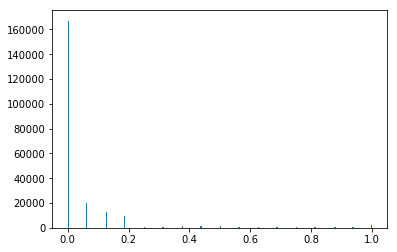

In [24]:
plt.hist(mean_test_prompt.reshape(-1),bins=200);


In [25]:
def f_train(i,j):
    arr= train_promot[i,j]
    idx=np.where(np.isnan(arr))[0]
    p=mean_test_prompt[i,j]
    #print p
    target_prompt=int(len(arr)*p)
    current_prompt=np.sum(arr==1)
    d=target_prompt-current_prompt
    arr[idx]=0
    if j==6:
        print i,j, "made additional", d,len(idx),p,target_prompt,current_prompt
    if d>0:
        if d >= len(idx):
            selected=idx
        else:
            selected=np.random.choice(idx,d,replace=False)
        arr[selected]=1
        

In [26]:
str(list(train_promot[2,6]))

'[nan, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

In [27]:
for i in range(train_promot.shape[0]):
    for j in range(train_promot.shape[1]):
        f_train(i,j)

0 6 made additional 817 17 0.5 844 27
1 6 made additional 821 40 0.5 844 23
2 6 made additional 822 21 0.5 844 22
3 6 made additional 821 22 0.5 844 23
4 6 made additional 802 12 0.5 844 42
5 6 made additional 709 21 0.4375 738 29
6 6 made additional 816 10 0.5 844 28
7 6 made additional 91 9 0.0625 105 14
8 6 made additional 0 1684 0.0 0 0
9 6 made additional 0 1688 0.0 0 0
10 6 made additional 0 1688 0.0 0 0
11 6 made additional 0 1687 0.0 0 0
12 6 made additional 0 1688 0.0 0 0
13 6 made additional 0 1687 0.0 0 0
14 6 made additional 0 1688 0.0 0 0
15 6 made additional 0 1688 0.0 0 0
16 6 made additional 0 1687 0.0 0 0
17 6 made additional 0 1688 0.0 0 0
18 6 made additional 0 1688 0.0 0 0
19 6 made additional 0 1687 0.0 0 0
20 6 made additional 0 1688 0.0 0 0
21 6 made additional 0 1688 0.0 0 0
22 6 made additional 395 46 0.25 422 27
23 6 made additional 81 207 0.0625 105 24
24 6 made additional -22 135 0.0 0 22
25 6 made additional 802 78 0.5 844 42
26 6 made additional 711 182 0.

In [28]:
print 'train (nan percent, mean)', np.isnan(train_promot).mean(),np.nanmean(train_promot[train_promot>=0],dtype=np.float)

train (nan percent, mean) 0.0 0.0579896472631


In [29]:
print 'test (nan percent, mean)', np.isnan(test_promot).mean(),np.nanmean(test_promot,dtype=np.float)

test (nan percent, mean) 0.0 0.0560628387534


In [30]:
print 'data (nan percent, mean)', np.isnan(data).mean(),np.nanmean(data,dtype=np.float)

data (nan percent, mean) 0.0 -0.00276435752425


In [31]:
print data.min(),data.max()

-1.0 1.0


In [32]:
data.shape,data.dtype

((54, 4100, 1704), dtype('float16'))

In [33]:
str(list(train_promot[2,6]))

'[1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

In [34]:
np.savez_compressed("../input/s/onpromotion_0", data)

In [35]:
gc.collect()

31516

### oil

In [44]:
oil=pd.read_csv("../input/oil.csv",parse_dates=['date'], date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d'),index_col=0).sort_index()

In [45]:
print oil.shape
oil.head()

(1218, 1)


dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20

In [46]:
oil=oil.reindex(days_idx.keys()).sort_index()
print oil.shape
oil.head()

(1704, 1)


dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-05         NaN

In [47]:
oil=oil.fillna(method='ffill').fillna(method='bfill')
oil.head()

dcoilwtico
date                  
2013-01-01       93.14
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-05       93.12

In [48]:
oil.index=oil.index.map(lambda u: days_idx[u])

In [49]:
oil.max()

dcoilwtico    110.62
dtype: float64

In [50]:
oil.head()

dcoilwtico
date            
0          93.14
1          93.14
2          92.97
3          93.12
4          93.12

In [51]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.ones(shape=dim,dtype=np.float16)

377265600


In [52]:
data=data*(oil['dcoilwtico'].values.astype(np.float16).reshape([1,1,-1]))

In [53]:
data.nbytes/1024.**2

719.5770263671875

In [54]:
np.savez_compressed("../input/s/oil_0", data)

In [55]:
gc.collect()

79

## 900 flag

In [56]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.zeros(shape=dim,dtype=np.float16)

377265600


In [57]:
data[:,:,900:]=1

In [58]:
data.nbytes/1024.**2

719.5770263671875

In [59]:
np.savez_compressed("../input/s/d900", data)

### holiday

In [60]:
stores=pd.read_csv("../input/stores.csv")
stores['store_nbr']=stores['store_nbr'].map(lambda u: stores_idx[u])

In [61]:
stores.head()

store_nbr           city                           state type  cluster
0          0          Quito                       Pichincha    D       13
1          1          Quito                       Pichincha    D       13
2          2          Quito                       Pichincha    D        8
3          3          Quito                       Pichincha    D        9
4          4  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [62]:
end_date =pd.to_datetime('2017-08-31')
start_date=pd.to_datetime('2013-01-01')

In [63]:
holiday=pd.read_csv("../input/holidays_events.csv", parse_dates=['date'], date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d'))

In [64]:
holiday=holiday[holiday['date']>=start_date]
holiday=holiday[holiday['date']<=end_date]
holiday.shape

(287, 6)

In [65]:
holiday['date']=holiday['date'].map(lambda u: days_idx[u])

In [66]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.ones(shape=dim,dtype=np.float16)
data.fill(np.nan)
print data.nbytes/1024.**2

377265600
719.577026367


In [67]:
country_holiday=holiday[holiday['locale']=='National']
print country_holiday.shape
country_holiday.head()

(151, 6)


date      type    locale locale_name                         description  \
41     0   Holiday  National     Ecuador                  Primer dia del ano   
42     4  Work Day  National     Ecuador             Recupero puente Navidad   
43    11  Work Day  National     Ecuador  Recupero puente primer dia del ano   
44    41   Holiday  National     Ecuador                            Carnaval   
45    42   Holiday  National     Ecuador                            Carnaval   

    transferred  
41        False  
42        False  
43        False  
44        False  
45        False

In [68]:
data[:,:,country_holiday['date'].values]=1

In [69]:
np.nansum(data.astype(np.float64))/prod(data.shape)

0.086267605633802813

In [70]:
state_holiday=holiday[holiday['locale']=='Regional']
print state_holiday.shape
state_holiday.head()

(18, 6)


date     type    locale                     locale_name  \
47    90  Holiday  Regional                        Cotopaxi   
58   175  Holiday  Regional                        Imbabura   
76   309  Holiday  Regional  Santo Domingo de los Tsachilas   
77   310  Holiday  Regional                     Santa Elena   
96   455  Holiday  Regional                        Cotopaxi   

                           description  transferred  
47       Provincializacion de Cotopaxi        False  
58       Provincializacion de Imbabura        False  
76  Provincializacion de Santo Domingo        False  
77       Provincializacion Santa Elena        False  
96       Provincializacion de Cotopaxi        False

In [71]:
state_holiday=pd.merge(state_holiday,stores, left_on='locale_name', right_on="state")

In [72]:
print state_holiday.isnull().sum().sum(),state_holiday.shape
state_holiday.head()

0 (31, 11)


date   type_x    locale locale_name                    description  \
0    90  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
1    90  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2   455  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
3   455  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
4   820  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

   transferred  store_nbr       city     state type_y  cluster  
0        False         11  Latacunga  Cotopaxi      C       15  
1        False         12  Latacunga  Cotopaxi      C       15  
2        False         11  Latacunga  Cotopaxi      C       15  
3        False         12  Latacunga  Cotopaxi      C       15  
4        False         11  Latacunga  Cotopaxi      C       15

In [73]:
data[state_holiday['store_nbr'].values,:,state_holiday['date'].values]=1

In [74]:
np.nansum(data.astype(np.float64))/prod(data.shape)

0.086593635889410533

In [75]:
locale_holiday=holiday[holiday['locale']=='Local']
print locale_holiday.shape
locale_holiday.head()

(118, 6)


date     type locale locale_name                description  transferred
46    60  Holiday  Local       Manta         Fundacion de Manta        False
48   101  Holiday  Local      Cuenca        Fundacion de Cuenca        False
49   103  Holiday  Local    Libertad  Cantonizacion de Libertad        False
50   110  Holiday  Local    Riobamba  Cantonizacion de Riobamba        False
54   131  Holiday  Local        Puyo     Cantonizacion del Puyo        False

In [76]:
locale_holiday=pd.merge(locale_holiday,stores, left_on='locale_name', right_on="city")

In [77]:
print locale_holiday.isnull().sum().sum(),locale_holiday.shape
locale_holiday.head()

0 (381, 11)


date   type_x locale locale_name         description  transferred  \
0    60  Holiday  Local       Manta  Fundacion de Manta        False   
1    60  Holiday  Local       Manta  Fundacion de Manta        False   
2   425  Holiday  Local       Manta  Fundacion de Manta        False   
3   425  Holiday  Local       Manta  Fundacion de Manta        False   
4   790  Holiday  Local       Manta  Fundacion de Manta        False   

   store_nbr   city   state type_y  cluster  
0         51  Manta  Manabi      A       11  
1         52  Manta  Manabi      D       13  
2         51  Manta  Manabi      A       11  
3         52  Manta  Manabi      D       13  
4         51  Manta  Manabi      A       11

In [78]:
data[locale_holiday['store_nbr'].values,:,locale_holiday['date'].values]=1

In [79]:
np.nansum(data.astype(np.float64))/prod(data.shape)

0.090495131281516261

In [80]:
data.shape,data.dtype

((54, 4100, 1704), dtype('float16'))

In [81]:
data.nbytes/1024.**2

719.5770263671875

In [82]:
np.savez_compressed("../input/s/holiday_0", data)

In [83]:
import gc
gc.collect()

367